# **Machine Learning Techniques Project**


*   Nicolas Bedoya Figueroa
*   Daniel Escalante Perez
*   Marilyn Stephany Joven Fonseca
*   Eder Leandro Carbonero Baquero

## **Utils**

In [ ]:
!pip3 install nltk pyspellchecker tqdm emoji nlpaug transformers tensorflow

In [ ]:
!pip3 install seaborn transformers torch tqdm

In [ ]:
!pip3 install umap-learn plotly

In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from spellchecker import SpellChecker
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
import nlpaug.augmenter.word as naw
from nlpaug.util import Action
import emoji
import random
import math
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

Librerias ML y DL

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import umap
import plotly.express as px
import ast

## **Data preprocessing**

### **Dataset 1: Davidson et al. 2017**

In [ ]:
# Load the dataset
davidson = pd.read_csv("./data/davidson_2017.csv")[["class", "tweet"]]
davidson.head()

In [ ]:
# Original class labels: 0 - hate speech, 1 - offensive language, 2 - neither
# Transform the label in 1: toxic and 0: non toxic
davidson["class"] = davidson["class"].replace({0: 1, 2: 0})
davidson["class"].value_counts()

In [ ]:
print("Rows:", davidson.shape[0])
print("Columns:", davidson.shape[1])

### **Dataset 2: HASOC (2019) English**

In [ ]:
hasoc = pd.read_csv("./data/HASOC_EN.tsv",sep = '\t')[["text","task_1"]]
hasoc.head()

In [ ]:
# Transform the label to 1: toxic and 0: non toxic
hasoc["task_1"] = hasoc["task_1"].replace({"HOF": 1, "NOT": 0})
hasoc["task_1"].value_counts()

In [ ]:
# Change column names to match the other datasets
hasoc = hasoc.rename(columns={'task_1': 'class', 'text': 'tweet'})
hasoc.head()

In [ ]:
print("Rows:", hasoc.shape[0])
print("Columns:", hasoc.shape[1])

### **Dataset 3: Zeerak Talat’s Hate Speech Dataset**

In [ ]:
# Load the dataset
zeerak = pd.read_csv("./data/NAACL_SRW_2016_fixed.csv")[["class", "text"]]
zeerak.head()

In [ ]:
# Original class labels
zeerak["class"].value_counts()

In [ ]:
# Transform the label to 1: toxic and 0: non toxic
zeerak["class"] = zeerak["class"].replace({"sexism": 1, "racism": 1, "none": 0})
zeerak["class"].value_counts()

In [ ]:
# Rename the columns to match the other datasets
zeerak = zeerak.rename(columns={'text': 'tweet'})
zeerak.head()

In [ ]:
print("Rows:", zeerak.shape[0])
print("Columns:", zeerak.shape[1])

### **Concatenation**

In [ ]:
data = pd.concat([davidson, hasoc, zeerak], axis=0, ignore_index=True)
data.head()

In [ ]:
data["class"].value_counts()

In [ ]:
print("Rows:", data.shape[0])
print("Columns:", data.shape[1])

### **Cleaning**

In [ ]:
#Check point
# Creation of one dataset for embedding of text into a vector and another one for embbeding with GloVe + Twitter
data_cleaning = data.copy()
data_cleaning_slight = data.copy()

In [ ]:
# Transform emojis into words

def emoji_to_words(text):
  return emoji.demojize(text, language='en')

data_cleaning['tweet'] = data_cleaning['tweet'].apply(emoji_to_words)
data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(emoji_to_words)

In [ ]:
# Remove URLs from tweets

def remove_urls(text):
  return re.sub(r'http\S+', '', text)

data_cleaning['tweet'] = data_cleaning['tweet'].apply(remove_urls)
data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(remove_urls)

In [ ]:
# Remove mentions from tweets
def remove_mentions(text):
  return re.sub(r'@\w+', '', text)

data_cleaning['tweet'] = data_cleaning['tweet'].apply(remove_mentions)


In [ ]:
# Remove symbols from tweets

def leave_letters(text):
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  return text

data_cleaning['tweet'] = data_cleaning['tweet'].apply(leave_letters)

In [ ]:
# Remove uncommon symbols from tweets

def clean_tweet_for_glove(text):
  # Keep only letters, numbers, hashtags, mentions, apostrophes, emojis, and basic punctuation
  text = re.sub(r"[^a-zA-Z0-9@#'’!?.,\s]", '', text)  # keep @, #, apostrophes, basic punctuation
  text = re.sub(r'\s+', ' ', text)  # replace multiple spaces with single space
  return text.strip()

data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(clean_tweet_for_glove)

In [ ]:
# Remove symbols from tweets

def lowercase(text):
  return text.lower()

data_cleaning['tweet'] = data_cleaning['tweet'].apply(lowercase)
data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(lowercase)

In [ ]:
# Correct spelling
spell = SpellChecker()

def correct_spelling(text):
  words = text.split()
  corrected_words = [spell.correction(word) or word for word in words]
  return ' '.join(corrected_words)

data_cleaning['tweet'] = [correct_spelling(text) for text in tqdm(data_cleaning['tweet'])]

In [ ]:
data_cleaning.head(2)

In [ ]:
# Remove stopwords

def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))  # Use English stop words
  words = text.split()
  filtered_words = [word for word in words if word not in stop_words]
  return " ".join(filtered_words)

data_cleaning['tweet'] = data_cleaning['tweet'].apply(remove_stopwords)

In [ ]:
# Stemming the words

stemmer = PorterStemmer()

def stem_text(text):
  words = text.split()
  stemmed_words = [stemmer.stem(word) for word in words]
  return " ".join(stemmed_words)

In [ ]:
data_cleaning['tweet'].head(200)

In [ ]:
data_cleaning_slight['tweet'].head(200)

In [ ]:
# Check and remove duplicates
def check_remove_dup(dataset):
  print(f'Duplicates: {dataset["tweet"].duplicated().sum()}')
  duplicated_tweets = dataset["tweet"].duplicated()
  return dataset[~duplicated_tweets]

In [ ]:
# Check and remove duplicates in the first dataset

data_cleaning = check_remove_dup(data_cleaning)

In [ ]:
# Check and remove duplicates in the second dataset

data_cleaning_slight = check_remove_dup(data_cleaning_slight)


In [ ]:
# Check for null or empty 

def check_null_empty(dataset):
  keep = ~((dataset["tweet"].isnull()) | (dataset["tweet"] == ""))
    
  print(f'Number of nulls or empty: {(~keep).sum()}')
    
  dataset = dataset[keep]
    
  print(f'Cleaned data shape: {dataset.shape}')

  return dataset

In [ ]:
# Check for null or empty in the first dataset

data_cleaning = check_null_empty(data_cleaning)

In [ ]:
# Check for null or empty in the second dataset

data_cleaning_slight = check_null_empty(data_cleaning_slight)

In [ ]:
# Checking the dataset's balance

data_cleaning["class"].value_counts()

In [ ]:
# Checking the dataset's balance

data_cleaning_slight["class"].value_counts()

In [ ]:
# Function to get a random synonym of a word

def get_synonym(word):
  synonyms = []
  for syn in wordnet.synsets(word):
    for lemma in syn.lemmas():
      synonyms.append(lemma.name())
  if len(synonyms) > 0:
    synonyms = list(set(synonyms))
    return synonyms[random.randint(0, len(synonyms) - 1)]
  else:
    return ""

In [ ]:
# Custom random insertion function

def random_synonym_insert_augment(text, alpha):

  words = text.split()
  new_text = words.copy()
  for word in words:
    if random.random() < alpha:
      synonym = get_synonym(word)
      if synonym != "":
        position = random.randint(0, len(new_text) - 1)
        new_text.insert(position, synonym)

  return [" ".join(new_text)]

In [ ]:
# Balance the data set using easy data augmentation

#Choose an alpha parameter (Percentage of words in a sentence that are changed)
alpha = 0.25

aug_synonym = naw.SynonymAug(aug_src='wordnet', aug_p = alpha)
aug_swap = naw.RandomWordAug(action="swap", aug_p = alpha)
aug_delete = naw.RandomWordAug(action="delete", aug_p = alpha)


def data_augmentation(dataset, alpha):
  # Store the new rows
  new_rows = []

  # Size to balance the classes
  desired_size = len(dataset[dataset['class'] == 1]) - len(dataset[dataset['class'] == 0])

  non_toxic = dataset[dataset['class'] == 0]

  # Until balanced
  while len(new_rows) < desired_size:
    # Get a random sample from the minority class
    random_row = non_toxic.sample(1)

    # Pick a random EDA technique and apply it
    random_num = random.randint(1, 4)
    augmented_text = []

    if random_num == 1:
      augmented_text = aug_synonym.augment(random_row['tweet'].values[0])
    elif random_num == 2:
      augmented_text = aug_swap.augment(random_row['tweet'].values[0])
    elif random_num == 3:
      augmented_text = random_synonym_insert_augment(random_row['tweet'].values[0], alpha)
    else:
      augmented_text = aug_delete.augment(random_row['tweet'].values[0])

    if len(augmented_text) > 0:
      new_rows.append({ "tweet": augmented_text[0], "class": random_row['class'].values[0] })


  # New rows dataframe
  new_rows_df = pd.DataFrame(new_rows)

  # Concatenate the datasets
  return pd.concat([dataset, new_rows_df], ignore_index = True, axis = 0)

In [ ]:
# Balance the first dataset

balanced_data = data_augmentation(data_cleaning, alpha)

print(f'Balanced data shape: {balanced_data.shape}')
print()
balanced_data["class"].value_counts()


In [ ]:
# Balance the second dataset

balanced_data_glove = data_augmentation(data_cleaning_slight, alpha)

print(f'Balanced data shape: {balanced_data_glove.shape}')
print()
balanced_data_glove["class"].value_counts()

In [ ]:
# Check and remove duplicates again that could have appeared due to augmentation

balanced_data = check_remove_dup(balanced_data)

In [ ]:
# Check and remove duplicates again that could have appeared due to augmentation in the second dataset

balanced_data_glove = check_remove_dup(balanced_data_glove)

In [ ]:
# Check for null or empty again if they appeared due to augmentation

balanced_data = check_null_empty(balanced_data)

In [ ]:
# Check for null or empty again if they appeared due to augmentation in the second dataset

balanced_data_glove = check_null_empty(balanced_data_glove)

In [ ]:
# Final distribution

balanced_data["class"].value_counts()

In [ ]:
# Final distribution

balanced_data_glove["class"].value_counts()

In [ ]:
balanced_data.to_csv('balanced_data.csv', index=False)

In [ ]:
balanced_data_glove.to_csv('balanced_data_glove.csv', index=False)

## **Embedding GloVe + Twitter**

### **Downloading and loading GloVe + Twitter**

In [ ]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

In [ ]:
!unzip glove.twitter.27B.zip

In [ ]:
embeddings_dict = {}
with open("glove.twitter.27B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = list(map(float, values[1:]))
        embeddings_dict[word] = vector

### **Embedding**

In [ ]:
# Tokenization of texts

balanced_data_glove = pd.read_csv('balanced_data_glove.csv')

tweets = balanced_data_glove["tweet"].astype(str).tolist()

tweets = [word_tokenize(tweet) for tweet in tweets]

In [ ]:
# Vectorization of texts

dimension = 100

def get_vector_from_tokens(tokens):
    vectors = []
    for token in tokens:
        if token in embeddings_dict:
            vectors.append(embeddings_dict[token])
        else:
            vectors.append(np.zeros(dimension))
    return np.array(vectors)

In [ ]:
tweet_embedding = [get_vector_from_tokens(tweet) for tweet in tweets]

In [ ]:
# Max length for padding

max_length = int(np.percentile([len(embedding) for embedding in tweet_embedding], 90))
max_length

In [ ]:
# Padding for equal sequence lengths

padded_tweets = pad_sequences(tweet_embedding, maxlen = max_length, dtype = 'float32', padding = 'post', truncating = 'post', value = 0.0)

In [ ]:
padded_tweets.shape

In [ ]:
np.save('embeddings_data_glove.npy', padded_tweets)

## **Embeddings Contextuales BERT**

In [ ]:
model_name = 'cardiffnlp/twitter-roberta-base'
max_len = 64

tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
model_roberta = AutoModel.from_pretrained(model_name)
model_roberta.eval()

In [ ]:
data = pd.read_csv('balanced_data.csv')
tweets = data['tweet'].astype(str).tolist()

In [ ]:
def mean_pooling(outputs, attention_mask):
    token_embeddings = outputs.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = input_mask_expanded.sum(1)
    return sum_embeddings / sum_mask

In [ ]:
def generate_embeddings(texts, model, tokenizer, max_len=64, device=None):
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    embeddings_cls = []
    embeddings_mean = []

    for text in tqdm(texts, desc='Generando embeddings'):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=max_len)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)

        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        embeddings_cls.append(cls_embedding)

        mean_embedding = mean_pooling(outputs, inputs['attention_mask']).squeeze().cpu().numpy()
        embeddings_mean.append(mean_embedding)

    return embeddings_cls, embeddings_mean

In [ ]:
embeddings_cls, embeddings_mean = generate_embeddings(tweets, model_roberta, tokenizer_roberta, max_len)

data["embedding_cls"] = [vec.tolist() for vec in embeddings_cls]
data["embedding_mean"] = [vec.tolist() for vec in embeddings_mean]

data.to_csv('data/embeddings_data.csv',index=False)

In [ ]:
!pip3 install --upgrade nbformat

In [ ]:
df = pd.read_csv("data/embeddings_data.csv")
df["embedding_mean"] = df["embedding_mean"].apply(ast.literal_eval)
X = np.vstack(df["embedding_mean"].values)
labels = df["class"].astype(str) if "class" in df.columns else None

reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = reducer.fit_transform(X)

fig = px.scatter_3d(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    z=X_umap[:, 2],
    color=labels,
    title="UMAP 3D de embeddings de tweets",
    labels={"color": "Clase"}
)
fig.show()

## **Machine Learning Models**

### **Nicolas Bedoya Figueroa**

### **Daniel Escalante Perez**

### **Marilyn Stephany Joven Fonseca**

### **Eder Leandro Carbonero Baquero**

Regression logistica
 Red neuronal convolucional CNN

#### Logistic regression

##### Carga de datos

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# === 1. CARGAR DATOS ===
df_rg = pd.read_csv('data/embeddings_data.csv')  # ← Archivo fuente

# Convertir la columna embedding_mean de string a lista de floats
df_rg['embedding_mean'] = df_rg['embedding_mean'].apply(ast.literal_eval)

# === 2. PREPARAR FEATURES Y LABELS ===
X = np.vstack(df_rg['embedding_mean'].values)  # (n_samples, 768)
y = df_rg['class'].values       

In [ ]:
# === 3. DIVIDIR EN TRAIN Y TEST ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 4. ENTRENAR MODELO DE REGRESIÓN LOGÍSTICA ===
log_reg_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
log_reg_model.fit(X_train, y_train)

# === 5. PREDICCIONES Y MÉTRICAS ===
y_pred = log_reg_model.predict(X_test)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir métricas
print(f"Accuracy: {accuracy:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [ ]:
# === 6. GUARDAR MÉTRICAS EN UN CSV ===

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame({
    'modelo': ['Regresión Logística'],
    'accuracy': [accuracy],
    'precision': [precision],
    'recall': [recall],
    'f1_score': [f1]
})

# Guardar en un archivo
metrics_df.to_csv('resultados_metricas.csv', index=False)

print("Métricas guardadas en 'resultados_metricas.csv'")

In [ ]:
import joblib

# Guardar el modelo entrenado
joblib.dump(log_reg_model, 'modelo_regresion_logistica.pkl')

print("Modelo guardado en 'modelo_regresion_logistica.pkl'")

In [ ]:
# Cargar el modelo desde el archivo
modelo_cargado = joblib.load('modelo_regresion_logistica.pkl')

# Usar el modelo cargado para hacer predicciones
nuevas_preds = modelo_cargado.predict(X_test)  # Por ejemplo, sobre X_test

##### Modelo de prediccón a partir de una sentencia

In [ ]:
!pip install transformers torch


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import joblib
import numpy as np

# === 1. CARGAR MODELOS ===
# Cargar modelo y tokenizer de CardiffNLP
model_name = 'cardiffnlp/twitter-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = AutoModel.from_pretrained(model_name)

# Cargar el modelo de regresión logística previamente guardado
modelo_clasificador = joblib.load('modelo_regresion_logistica.pkl')

# === 2. DEFINIR MÉTODO PARA PREDECIR ===
def predict_hate_speech(frase):
    # Tokenizar entrada
    inputs = tokenizer(
        frase,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128  # ← Agregado para evitar warnings
    )
    
    # Obtener embedding
    with torch.no_grad():
        outputs = embedding_model(**inputs)
    
    # Mean pooling
    last_hidden_state = outputs.last_hidden_state
    embedding_mean = last_hidden_state.mean(dim=1).numpy()

    # Predecir
    pred = modelo_clasificador.predict(embedding_mean)[0]
    
    # Interpretar predicción
    return "Hate Speech ⚠️" if pred == 1 else "No Hate Speech ✅"



In [ ]:
frase = "I hate you so much!"
resultado = predict_hate_speech(frase)
print(resultado)


In [ ]:
# Acceder a los coeficientes de la regresión logística
coeficientes = modelo_clasificador.coef_[0]  # (768,)

# Ordenar dimensiones por importancia
importancia_dims = np.argsort(coeficientes)[::-1]  # Mayor a menor

# Mostrar las 10 dimensiones más relacionadas con hate
print("Top 10 dimensiones más asociadas a hate speech:")
for idx in importancia_dims[:10]:
    print(f"Dimensión {idx} → Peso: {coeficientes[idx]:.4f}")


In [ ]:
from transformers import RobertaTokenizer

# Cargar el tokenizador de RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base')

# Acceder a los coeficientes de la regresión logística
coeficientes = modelo_clasificador.coef_[0]  # (768,)

# Ordenar dimensiones por importancia
importancia_dims = np.argsort(coeficientes)[::-1]  # Mayor a menor

# Mostrar las 10 palabras más asociadas a hate speech
print("Top 10 tokens más asociados a hate speech:")
for idx in importancia_dims[:10]:
    # Obtener el token asociado a esta dimensión
    token_id = idx  # El índice aquí corresponde al token ID de RoBERTa
    token = tokenizer.decode([token_id])  # Decodificar el token a una palabra/fragmento
    print(f"Token: {token} → Coeficiente: {coeficientes[idx]:.4f}")


Con base el los token con mayor coeficiente vamos a crear una frase aleatoria

## **Deep Learning Models**

### **Nicolas Bedoya Figueroa**

### **Daniel Escalante Perez**

### **Marilyn Stephany Joven Fonseca**

### **Eder Leandro Carbonero Baquero**

#### CNN

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Cargar el archivo CSV
df_cnn = pd.read_csv('data/embeddings_data.csv')

# Asegurarse de que los embeddings son listas de números
X = np.array(df_cnn['embedding_mean'].apply(eval).tolist())  # Convertir de string a lista
y = np.array(df_cnn['class'])  # Etiquetas: 0 o 1

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Asegurarse de que los datos tengan la forma correcta (n_samples, sequence_length, n_channels)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Verificar las formas de los datos para asegurarse de que están correctos
print(X_train.shape, X_test.shape)


(38164, 768, 1) (9541, 768, 1)


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir el modelo CNN con 5 capas
model = models.Sequential()

# Capa convolucional 1
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.MaxPooling1D(2))

# Capa convolucional 2
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

# Capa convolucional 3
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

# Capa convolucional 4
model.add(layers.Conv1D(512, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

# Capa convolucional 5
model.add(layers.Conv1D(1024, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

# Aplanar los resultados
model.add(layers.Flatten())

# Capa densa de salida
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Salida binaria (0 o 1)

# Compilar el modelo
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping

# Configurar el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 80s 83ms/step - accuracy: 0.7305 - loss: 0.5119 - precision: 0.7469 - recall: 0.7249 - val_accuracy: 0.8337 - val_loss: 0.3806 - val_precision: 0.9229 - val_recall: 0.7372
Epoch 2/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.8401 - loss: 0.3625 - precision: 0.8840 - recall: 0.7910 - val_accuracy: 0.8379 - val_loss: 0.3715 - val_precision: 0.9266 - val_recall: 0.7426
Epoch 3/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - accuracy: 0.8548 - loss: 0.3349 - precision: 0.8980 - recall: 0.8037 - val_accuracy: 0.8500 - val_loss: 0.3428 - val_precision: 0.8934 - val_recall: 0.8032
Epoch 4/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.8591 - loss: 0.3223 - precision: 0.8984 - recall: 0.8146 - val_accuracy: 0.8510 - val_loss: 0.3405 - val_precision: 0.8804 - val_recall: 0.8208
Epoch 5/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - accuracy: 0.8660 - loss: 0.3127 - precision: 0.9114 - recall: 0.8178 - val_accuracy: 0.8495 - va

In [4]:
# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Umbral para clasificación binaria

# Calcular métricas adicionales
accuracy = model.evaluate(X_test, y_test)[1]
precision = tf.keras.metrics.Precision()(y_test, y_pred)
recall = tf.keras.metrics.Recall()(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8470 - loss: 0.3419 - precision: 0.8933 - recall: 0.7964
Accuracy: 0.8505398035049438
Precision: 0.8966307640075684
Recall: 0.8004910945892334
F1 Score: 0.8458378378378378


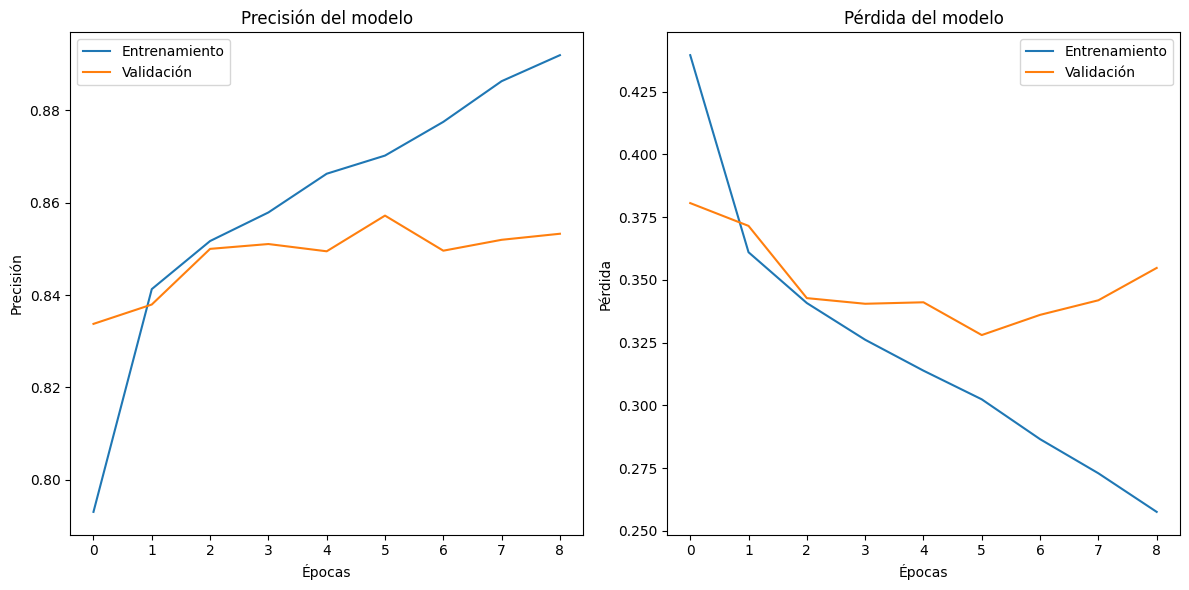

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener las métricas de entrenamiento y validación
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficar la precisión
plt.figure(figsize=(12, 6))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

Guardar el modelo

In [7]:
# Guardar el modelo entrenado en un archivo
model.save('cnn_trained_model.h5')

Predicción dada una frase

In [11]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import tensorflow as tf

# Cargar el tokenizador y el modelo de cardiffnlp/twitter-roberta-base
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")
model_roberta = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base")

# Función para obtener el embedding de un texto
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model_roberta(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

# Función para predecir si es hate speech
def predict_hate_speech(text, model):
    # Obtener el embedding del texto
    embedding = get_embedding(text)
    
    # Redimensionar el embedding para que tenga la forma adecuada
    embedding = embedding.reshape(1, -1)  # Forma (1, emb_size)
    
    # Asegurarse de que el modelo esté cargado correctamente
    if model is None:
        raise ValueError("El modelo no está cargado correctamente.")
    
    # Predicción con el modelo
    prediction = model.predict(embedding)
    
    # Clasificación: 0 = no hate speech, 1 = hate speech
    if prediction > 0.5:
        return "Hate Speech"
    else:
        return "No Hate Speech"

In [19]:
# Cargar el modelo previamente entrenado
model = tf.keras.models.load_model('cnn_trained_model.h5')  # Asegúrate de tener el modelo entrenado cargado
# Test de predicción
text = "bitch eat shit all day"  # Texto de ejemplo
result = predict_hate_speech(text, model)
print(f"Predicción: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicción: Hate Speech
